In [2]:
import pickle
import os
import tensorflow as tf
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d as Axes3D

from database import *
from sklearn.manifold import TSNE

%matplotlib inline

# Datasets

Generate training, testing, and validation datasets

In [12]:
# Import data from database
step = 1/10e3  # microphone sample period, sec
mic_list = ("Ambient", "Mic 0", "Mic 1", "Mic 2", "Mic 3")  # for setting the legend
fs = 1/step  # sample rate, Hz

In [57]:
# Load data from the database
# host = "mysql.ecn.purdue.edu"  # 128.46.154.164
# user = "op_point_test"
# database = "op_point_test"
host = 'localhost'
user = 'root'
database = 'mysql'
table_name = '100_op_point_test'
password = 'admin'
# with open("password.txt", "r") as f:
#   password = f.read().rstrip()
eng = connect_to_db(host, user, password, database)
tic = timeit.default_timer()
data = import_data(eng, table_name)
toc = timeit.default_timer()
if eng.open:
    eng.close()
print("Elapsed time: {} sec".format(toc-tic))

Number of rows: 42331
Keys: ['temperature', 'staticP', 'dateTimeStamp', 'opPointAct', 'atmosphericP', 'flameStatus', 'opPointDes', 'dynamicP']
Loading data ................................................... done!
Elapsed time: 54.44733872698271 sec


In [13]:
# Import processed data from pickle
processed_data = []
for mic in mic_list:
    fname = os.path.join('..', 'Processed', 'short_fft_waterfall_{}.pickle'.format(mic))
#     fname = os.path.join('.', 'Processed', 'short_fft_waterfall_softmax_{}.pickle'.format(mic))
    processed_data.append(pickle.load(open(fname, 'rb')))

In [19]:
fname = os.path.join('..', 'Processed', 'K-means_results_4_centroids.pickle')
kmeans_data = pickle.load(open(fname, 'rb'))
assignments = kmeans_data['assignments']
print(assignments)

[1 1 1 ..., 1 1 1]


In [20]:
print(np.power(10, np.mean([row['res'][0,:] for row in processed_data], axis=1)/20))

[ 0.02470229  0.02452491  0.02547168  0.02053213  0.02165319]


In [204]:
dataset = []
for num in range(data['opPointAct'].shape[0]):
    start = num*100
    vec = np.concatenate((data['flameStatus'][num],
                          data['opPointAct'][num],
                          data['staticP'][num],
#                           data['temperature'][num],
#                           np.concatenate([row['res'][num,:] for row in processed_data])), axis=0)
                          np.power(10, np.mean([row['res'][num,:] for row in processed_data], axis=1)/20)), axis=0)
#                           np.concatenate([row for row in data['dynamicP'][:, start:start+100]])), axis=0)
    dataset.append(vec)
    
dataset = np.array(dataset)
dataset.shape

(42332, 11)

In [229]:
labelset = np.zeros((len(assignments), np.max(assignments)+1), dtype=np.float32)
for i in range(len(assignments)):
    labelset[i, assignments[i]] = 1  # encode assignments as one-hot vectors
print(labelset.shape)
print('Assignments: {}'.format(assignments[1000:1010]))
print('One-hot encoded:\n{}'.format(labelset[1000:1010]))

(42332, 4)
Assignments: [1 1 1 1 3 1 1 1 1 1]
One-hot encoded:
[[ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]]


In [230]:
input_size = dataset.shape[1]
num_samples = dataset.shape[0]
batch_size = 64
num_unrollings = 10

In [231]:
output_size = labelset.shape[1]

In [208]:
class BatchGenerator(object):
    def __init__(self, data, batch_size, num_unrollings):
        self._data = data
        self._num_samples = data.shape[0]
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._num_samples // batch_size
        self._offset = 0
        self._last_batch = self._next_batch()

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = self._data[self._offset:self._offset+self._batch_size, :]
        self._offset += self._batch_size
        if self._num_samples - self._offset < self._batch_size:
            self._offset = 0
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

In [232]:
train_size = np.int(0.7*num_samples)
valid_size = len(dataset) - train_size
train_batches = BatchGenerator(dataset[:train_size,:], batch_size, num_unrollings)
valid_batches = BatchGenerator(dataset[train_size:,:], 1, 1)

In [233]:
train_label_batches = BatchGenerator(labelset[:train_size,:], batch_size, num_unrollings)
valid_label_batches = BatchGenerator(labelset[train_size:,:], 1, 1)

In [211]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10
    return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

# LSTM RNN Definition

Define the long short-term memory (LSTM) recurrent neural network (RNN). Borrowing heavily from the Deep Learning Udacity course.

In [235]:
num_nodes = 64  #TODO tune this!
num_steps = 1001

graph = tf.Graph()
with graph.as_default():
    # Parameters
    # Combined input, forget, memory cell, and output weights for input and previous state. Also biases.
    ifcox = tf.Variable(tf.truncated_normal([input_size, 4*num_nodes], 0.0, 1/np.sqrt(input_size)))
    ifcom = tf.Variable(tf.truncated_normal([num_nodes, 4*num_nodes], 0.0, 1/np.sqrt(input_size)))
    ifcob = tf.Variable(tf.zeros([1, 4*num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, output_size], 0.0, 1/np.sqrt(output_size)))
    b = tf.Variable(tf.zeros([output_size]))
    
    # Create saver
    saver = tf.train.Saver()
    
    # Definition of the cell computation
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        combined = tf.matmul(i, ifcox) + tf.matmul(o, ifcom) + ifcob
        input_gate = tf.sigmoid(combined[:, :num_nodes])
        forget_gate = tf.sigmoid(combined[:, num_nodes:2*num_nodes])
        update = combined[:, 2*num_nodes:3*num_nodes]
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(combined[:, 3*num_nodes:])
        return output_gate * tf.tanh(state), state
    
    # Input data
    train_data = list()
    train_labels = list()
    for _ in range(num_unrollings + 1):
        train_data.append(tf.placeholder(tf.float32, shape=[batch_size, input_size]))
        train_labels.append(tf.placeholder(tf.float32, shape=[batch_size, output_size]))
    train_inputs = train_data[:num_unrollings]
    train_outputs = train_labels[1:]  # labels are shifted by one time step.
    
    # Unrolled LSTM loop
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)
    
    # Saving state across unrollings
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier
        logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,
                tf.concat(0, train_outputs)))
#         loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,
#                               tf.concat(0, train_outputs)))
    
    # Optimizer
    global_step = tf.Variable(0)
#     learning_rate = tf.train.exponential_decay(10.0, global_step, 2*num_steps//3, 0.1, staircase=True)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer()
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, input_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(saved_sample_output.assign(tf.zeros([1, num_nodes])),
            saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(sample_input, saved_sample_output,
            saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

# Run

Train the network on the dataset and observe the performance

In [237]:
summary_frequency = 100
mean_loss = 0

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized.')
    for step in range(num_steps):
        # Generate next training batch
        batches = train_batches.next()
        labels = train_label_batches.next()
        
        # Generate feed_dict
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
            feed_dict[train_labels[i]] = labels[i]
        _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
#                 [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        
        # Update to the user periodically
        if step % summary_frequency == 0:
            # Output some information about our training performance
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step {}: {}'.format(step, mean_loss))
#             print('Average loss at step {}: {} learning rate: {}'.format(step, mean_loss, lr))            
            mean_loss = 0
            print('Minibatch perplexity: {}'.format(float(np.exp(logprob(predictions,
                    np.concatenate(labels[1:], axis=0))))))

    # Measure validation set perplexity.
    reset_sample_state.run()
    valid_logprob = 0
    for num in range(valid_size):
        b = valid_batches.next()
        l = valid_label_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, l[1])
    print('Validation set perplexity: {}'.format(float(np.exp(valid_logprob / valid_size))))
    
    save_path = saver.save(session, './tmp/model.ckpt')
    print('Model saved in file: {}'.format(save_path))

Initialized.
Average loss at step 0: 1.8605432510375977
Minibatch perplexity: 6.427228647055624
Average loss at step 100: 0.6526963956281543
Minibatch perplexity: 1.6904040362633899
Average loss at step 200: 0.4032594308909029
Minibatch perplexity: 1.9887653499130669
Average loss at step 300: 0.31086724060587584
Minibatch perplexity: 1.0191203828607283
Average loss at step 400: 0.30075304307974876
Minibatch perplexity: 1.371257316659087
Average loss at step 500: 0.29262957523576916
Minibatch perplexity: 1.0216511909795385
Average loss at step 600: 0.26312306433450433
Minibatch perplexity: 1.016561295492537
Average loss at step 700: 0.23408196100732312
Minibatch perplexity: 1.2741042533475435
Average loss at step 800: 0.27217657326254996
Minibatch perplexity: 1.0224087928284715
Average loss at step 900: 0.25333340830286033
Minibatch perplexity: 2.037988653795976
Average loss at step 1000: 0.24097797615802846
Minibatch perplexity: 1.1621022046498277
Validation set perplexity: 1.251480853

# Analyze

Analyze the performance and see what we can do with it

In [238]:
#TODO
with tf.Session(graph=graph) as session:
    saver.restore(session, './tmp/model.ckpt')
    print('Model restored.')
    reset_sample_state.run()
    valid_logprob = 0
    for num in range(10):
        b = valid_batches.next()
        l = valid_label_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = logprob(predictions, l[1])
        print('Logprob prediction accuracy: {}'.format(np.exp(valid_logprob)))

Model restored.
Logprob prediction accuracy: 3.27499509365031
Logprob prediction accuracy: 4.305346330370888
Logprob prediction accuracy: 5.848128092794755
Logprob prediction accuracy: 8.95032183870408
Logprob prediction accuracy: 21.192523869801214
Logprob prediction accuracy: 34.57237037931048
Logprob prediction accuracy: 33.55192325402382
Logprob prediction accuracy: 22.4291848650905
Logprob prediction accuracy: 11.539374057178454
Logprob prediction accuracy: 5.9423446453489825


# K-means clustering of dataset

Attempt to divide the data into `n` seperable clusters.

In [ ]:
blow_outs = [ind for ind in range(num_samples) if dataset[ind, 0] == 0]
print(blow_outs)

In [4]:
dist_history = []
n_clusters = 4

In [173]:
n_clusters = 4
def choose_random_centroids(samples, n_clusters):
    """Step 0: Initialisation: Select `num_clusters` number of random points."""
    random_indices = tf.random_shuffle(tf.range(0, num_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

tf.reset_default_graph()
kmeans = tf.Graph()
with kmeans.as_default():
    # def configure_kmeans(n_clusters):
    points = tf.constant(dataset[:num_samples])
    cluster_assignments = tf.Variable(tf.zeros([num_samples], dtype=tf.int64))

    # Initialize centroids to locations of `n_clusters` random samples
    centroids = tf.Variable(choose_random_centroids(points, n_clusters))

    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [num_samples, 1]), [num_samples, n_clusters, input_size])
    rep_points = tf.reshape(tf.tile(points, [1, n_clusters]), [num_samples, n_clusters, input_size])

    #TODO modify the cost function for k-means clustering.
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids),
                                reduction_indices=2)

    # Use argmin to select the lowest-distance point
    best_centroids = tf.argmin(sum_squares, 1)
    did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids, 
                                                        cluster_assignments))

    def bucket_mean(data, bucket_ids, num_buckets):
        total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
        count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
        return total / count

    means = bucket_mean(points, best_centroids, n_clusters)

    # Do not write to the assigned clusters variable until after
    # computing whether the assignments have changed - hence with_dependencies
    with tf.control_dependencies([did_assignments_change]):
        do_updates = tf.group(
            centroids.assign(means),
            cluster_assignments.assign(best_centroids))

In [183]:
max_iters = 1000  # stop criterion for k-means algorithm
repeats = 200//n_clusters  # number of times to train the same k-means, hoping to find a best result
progress = np.int(max_iters/50)
centers_hist = []
assignments_hist = []
mean_hist = []
# num_clusters = 4  # blowout, attached, detached, going unstable

with tf.Session(graph=kmeans) as sess:
    for _ in range(repeats):
        print('Working ', end='', flush=True)
        tic = timeit.default_timer()
        sess.run(tf.initialize_all_variables())
        changed = True
        iters = 0

        # Run k-means loop
        while changed and iters < max_iters:
            if iters % progress == 0:
                print('.', end='', flush=True)
            iters += 1
            [changed, _] = sess.run([did_assignments_change, do_updates])
        toc = timeit.default_timer()
        print(" {} clusters in {} seconds {} iterations".format(n_clusters, toc-tic, iters))

        # Save the results
        [centers, assignments] = sess.run([centroids, cluster_assignments])
        mean_dist = np.mean([dist[ind] for dist, ind in zip(sum_squares.eval(), assignments)], axis=0)
        centers_hist.append(centers)
        assignments_hist.append(assignments)
        mean_hist.append(mean_dist)
    
    min_ind = np.argmin(mean_hist)
    mean_dist = np.min(mean_hist)
    centers = centers_hist[min_ind]
    assignments = assignments_hist[min_ind]
#     dist_history.append(mean_dist)
    print("Centroids:")
    print(centers)
    print("Cluster assignments: ", assignments)
    print("Mean total distance to nearest: {}".format(mean_dist))

Working ... 4 clusters in 2.123286015004851 seconds 56 iterations
Working .. 4 clusters in 1.205297516018618 seconds 35 iterations
Working ... 4 clusters in 1.515310363000026 seconds 43 iterations
Working ... 4 clusters in 1.8613371510000434 seconds 54 iterations
Working ... 4 clusters in 1.889135391014861 seconds 55 iterations
Working ... 4 clusters in 1.6228490810026415 seconds 46 iterations
Working ... 4 clusters in 1.9520841219928116 seconds 57 iterations
Working ... 4 clusters in 1.9263376820017584 seconds 55 iterations
Working ... 4 clusters in 1.8011824430141132 seconds 51 iterations
Working ... 4 clusters in 1.8494822369830217 seconds 53 iterations
Working ... 4 clusters in 1.925706292007817 seconds 56 iterations
Working ... 4 clusters in 1.6322574579971842 seconds 47 iterations
Working ... 4 clusters in 2.0043468799849506 seconds 57 iterations
Working ... 4 clusters in 1.7660623250121716 seconds 51 iterations
Working ... 4 clusters in 1.4976058199827094 seconds 45 iterations
W

In [184]:
print(np.array(centers_hist)[:,:,0])

[[ 0.99630607  0.99488564  0.99789537  1.        ]
 [ 1.          0.99489217  0.99604326  0.9981982 ]
 [ 0.99879952  0.99551806  1.          0.99489072]
 [ 0.99789537  1.          0.99630607  0.99488564]
 [ 1.          0.99789537  0.99488564  0.99630607]
 [ 0.99551806  0.99489072  1.          0.99879952]
 [ 0.99789537  0.99630607  1.          0.99488564]
 [ 1.          0.99789537  0.99488564  0.99630607]
 [ 0.99630607  0.99789537  0.99488564  1.        ]
 [ 0.99488564  0.99789537  1.          0.99630607]
 [ 0.99789537  0.99488564  1.          0.99630607]
 [ 0.99879952  1.          0.99489072  0.99551806]
 [ 0.99630607  0.99789537  1.          0.99488564]
 [ 0.99488564  0.99630607  1.          0.99789537]
 [ 0.99879952  1.          0.99489072  0.99551806]
 [ 0.99630607  0.99789537  0.99488564  1.        ]
 [ 0.99879952  1.          0.99489072  0.99551806]
 [ 0.99789537  0.99630607  1.          0.99488564]
 [ 0.99630607  0.99789537  1.          0.99488564]
 [ 0.99630607  0.99789537  0.99

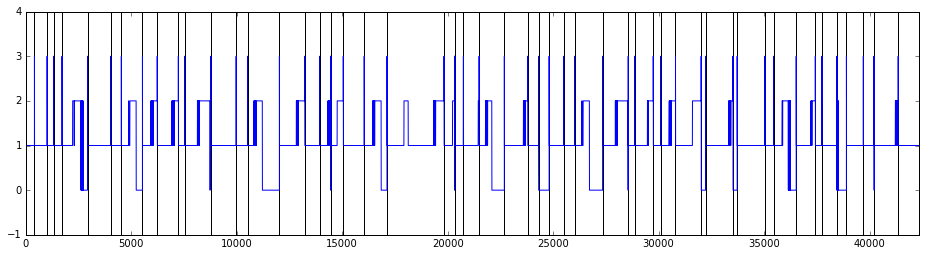

In [185]:
plt.figure(figsize=(16, 4))
plt.plot(assignments)
plt.vlines(blow_outs, -1, n_clusters)
plt.ylim((-1, n_clusters))
plt.xlim((0, num_samples))
plt.show()

[0.003633402953533608, 0.0023052109953605455, 0.0011415176818282244, 0.00082087457931507115, 0.00063532573266858092, 0.0005278953763293581]


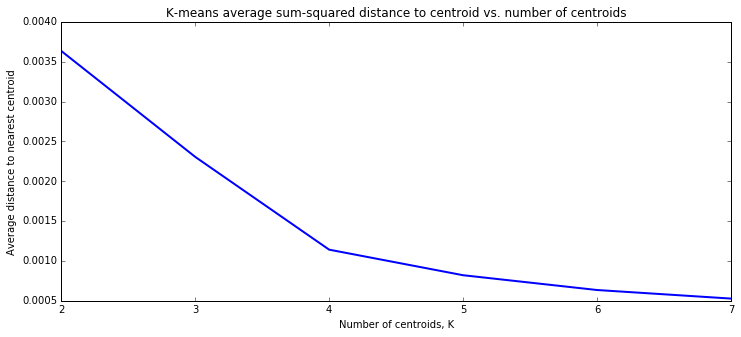

In [176]:
print(dist_history)
plt.figure(figsize=(12,5))
plt.plot(range(2, len(dist_history)+2), dist_history, linewidth=2)
plt.title('K-means average sum-squared distance to centroid vs. number of centroids')
plt.xlabel('Number of centroids, K')
plt.ylabel('Average distance to nearest centroid')
plt.show()

In [186]:
centers = np.array(centers)
assignments = np.array(assignments)
dist_history = np.array(dist_history)

In [7]:
fname = os.path.join('..', 'Processed', 'K-means_results_{}_centroids.pickle'.format(n_clusters))

In [1]:
to_pickle = {'centers': centers,
             'assignments': assignments,
             'distance_vs_num_centers': dist_history}
pickle.dump(to_pickle, open(fname, 'wb'))

NameError: name 'os' is not defined

In [8]:
kmeans_data = pickle.load(open(fname, 'rb'))
print(kmeans_data)

{'assignments': array([1, 1, 1, ..., 1, 1, 1]), 'centers': array([[ 1.        ,  2.81591334,  0.03357434,  0.07389693,  0.06184875,
         0.0206192 ,  0.02009801],
       [ 1.        ,  2.52701412,  0.02998303,  0.02804071,  0.02945956,
         0.02154577,  0.02185534],
       [ 1.        ,  2.63422938,  0.02761916,  0.03205354,  0.03003301,
         0.02001018,  0.01999879],
       [ 0.        ,  2.65465485,  0.01905372,  0.03090722,  0.02950687,
         0.01450436,  0.01280015]]), 'distance_vs_num_centers': array([ 0.0036334 ,  0.00230521,  0.00114152,  0.00082087,  0.00063533,
        0.0005279 ])}


In [10]:
kmeans_data['assignments'].shape

(42332,)

# Visualize Clustering

Visualize the data ponit clustering with [t-SNE][1]

[1]: http://lvdmaaten.github.io/tsne/

In [24]:
fname = os.path.join('..', 'Processed', 'tSNE_dataset.pickle')
dataset = pickle.load(open(fname, 'rb'))
dataset['data'].shape

(42332, 12)

In [54]:
print(dataset['data'][:10, :])

[[ 1.          0.82210712  0.00347287  1.90539265  0.13823419  2.52919102
   1.          0.02470229  0.02452491  0.02547168  0.02053213  0.02165319]
 [ 1.          0.81983404  0.00314814  1.9060421   0.13726001  2.50678493
   1.          0.02014168  0.02377203  0.02536654  0.02006923  0.02061006]
 [ 1.          0.82048349  0.00282342  1.90669155  0.13920837  2.5139289
   1.          0.02053943  0.02495976  0.02576064  0.01994754  0.02227426]
 [ 1.          0.82275657  0.00347287  1.9060421   0.14180617  2.5239954
   1.          0.02190999  0.01922343  0.02036909  0.01675647  0.01798007]
 [ 1.          0.82048349  0.00379759  1.9060421   0.13855891  2.50873329
   1.          0.01917183  0.02661078  0.02818813  0.0205611   0.02051865]
 [ 1.          0.82015876  0.00379759  1.90636682  0.13888364  2.51717616
   1.          0.0232448   0.02063994  0.02166557  0.0174074   0.01953536]
 [ 1.          0.82405547  0.00347287  1.90571737  0.13693528  2.5139289
   1.          0.02660757  0.021064

In [ ]:
num_points = dataset['data'].shape[0]

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(dataset['data'][:num_points, :])

In [ ]:
list0 = two_d_embeddings[dataset['data'][:num_points, 6] == 0]
list1 = two_d_embeddings[dataset['data'][:num_points, 6] == 1]
list2 = two_d_embeddings[dataset['data'][:num_points, 6] == 2]
list3 = two_d_embeddings[dataset['data'][:num_points, 6] == 3]

In [ ]:
colors = ('b', 'r', 'y', 'g')
plt.figure()
cat0 = plt.scatter(list0[:, 0], list0[:, 1], color=colors[0])
cat1 = plt.scatter(list1[:, 0], list1[:, 1], color=colors[1])
cat2 = plt.scatter(list2[:, 0], list2[:, 1], color=colors[2])
cat3 = plt.scatter(list3[:, 0], list3[:, 1], color=colors[3])
plt.show()